In [1]:
import numpy as np
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr
import itertools
from scipy.special import erfc
import galois
import random
from Dec import Dec

### Decoder Class

In [2]:
import math
import numpy as np

class Dec_reldec:
    
    def __init__ (self,H, channel_model, channel_parameters, num_iter,cluster_size):
        # code parameters
        self.n = H.shape[1]
        self.k = self.n - H.shape[0]
        self.H = H
        self.model = channel_model
        self.params = channel_parameters
        self.num_iter = num_iter
        
        # misc parameters (epsilon : for numerical stability)
        self.ep = 1e-5
        
        # graph parameters
        self.num_VN = self.n
        self.num_CN = self.n-self.k
        self.cluster_size = cluster_size
        
        # adjacency list for VN and CN
        self.CN = []
        self.VN = []
        self.construct_graph(H)
        self.initialize_clusters(self.cluster_size)
        self.iteration_number = 0
        self.policy = None # policy for choosing clusters (using RL)
    
        
        # determine l_star = max(la)
        self.l = [0]*self.num_clusters
        l_star = -1
        ind = 0
        for cluster in self.clusters:
            st = set()
            for i in cluster:
                st.update(self.CN[i])
            l_a = len(st)
            self.l[ind] = l_a
            ind = ind + 1
            l_star = max(l_star,l_a)
        self.l_star = l_star
        
        self.cluster_bits = math.ceil(math.log2(self.num_clusters))
        self.cluster_state_bits = self.l_star


        
    # build the adjacency list for Tanner Graph
    def construct_graph(self,H):
        for i in range(self.num_CN):
            temp = []
            for j in range(self.num_VN):
                if H[i,j]==1:
                    temp.append(j)
            self.CN.append(temp)
            
        for i in range(self.num_VN):
            temp = []
            for j in range(self.num_CN):
                if H[j,i]==1:
                    temp.append(j)
            self.VN.append(temp)
    
    # print the tanner graph
    def print_graph(self,mode):
        if mode=="matrix":
            print(self.H)
        elif mode=="list":
            print('CN : ',self.CN)
            print('VN : ',self.VN)
        else:
            print('Invalid mode')
    
    
    # initialize clusters of CNs
    def initialize_clusters(self,cluster_size):
        self.num_clusters = math.ceil(self.num_CN/cluster_size)
        self.clusters = []
        for i in np.arange(0,self.num_CN,cluster_size):
            temp = []
            for j in range(i,min(i+cluster_size,self.num_CN)):
                temp.append(j)
            self.clusters.append(temp)   
                    
    # returns the absolute min, 2nd min and parity of the input array
    def get_min(self,arr):
        arr = np.array(arr)
        arr = arr[~np.isnan(arr)]
        parity = np.prod(np.sign(arr))
        if len(arr) < 2:
            print("arr = ",arr)
            raise ValueError("Not enough valid elements in the array.")
        arr = np.sort(np.abs(arr))
        return arr[0],arr[1],parity
    
    # perform row update of cluster a 
    def row_update(self,a):
        # subtract step (removing known beliefs)
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] - tot

        # flow down the sum into the cluster a
        for j in range(self.num_VN):
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = self.sum[j]

        # perform minsum for each row
        for i in self.clusters[a]:
            if len(self.L[i])==0:
                print(f"finding L[{i}] where L is :",L)

            m1,m2,p = self.get_min(self.L[i])
            for j in range(self.num_VN):
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = p*np.sign(self.L[i,j])*m2 if np.abs(self.L[i,j])==m1 else p*np.sign(self.L[i,j])*m1

    def col_update(self,a):
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] + tot

    def decode(self,y,verbose="off"):
        # sum is initialized by incoming beliefs (initial LLRs)
        self.sum = y
        
        # initializing the storage matrix
        self.L = np.full(self.H.shape, np.nan, dtype=float)  # Initialize with NaNs
        for i in range(self.num_CN):
            for j in range(self.num_VN):
                self.L[i,j] = 0 if self.H[i,j]==1 else np.nan
                
#         a = random.randint(0, self.num_clusters - 1)
        a = 0
        for k in range(self.num_iter):
            self.iteration_number = k
            a = self.get_next_cluster(a,k)
            if verbose=="on":
                print("Iteration : ",k,"\tCluster scheduled : ",a)
            self.row_update(a)
            self.col_update(a)
            c_hat = np.array([1 if val<0 else 0 for val in self.sum])
            if self.stopping_criteria(k,c_hat):
                break
        return c_hat
        
    def stopping_criteria(self,k,c_hat):
        c1 = k>self.num_iter
        c2 = (np.sum(np.dot(self.H,c_hat.T)%2)==0)
        return c1 or c2
    
    def get_next_cluster(self,a,iter_number):
        
        # round robin scheduling
        # return (iter_number%self.num_clusters)
        
        # reldec scheduling
        return pi[self.encode_state(a,self.get_cluster_state(a))]

        # random scheduling
#         return random.randint(0, self.num_clusters - 1)
    
    def get_cluster_state(self, a):
#         print(f"CN : {self.CN}")
#         print("Getting cluster state for a = ",a)
        st = set()
        for i in self.clusters[a]:
            st.update(self.CN[i])
#         print(f"N({a})={st}")
        num = 0
        for j in st:
            bit = 1 if self.sum[j]<0 else 0
            num = (num<<1)+bit
        for k in range(self.l_star - self.l[a]):
            num = (num<<1)
        return num
    
    def encode_state(self, cluster, cluster_state):
        # takes in cluster number [0 to q-1] and cluster_state [0 to 2^l_a] and encodes it to a number
        # state = [cluster_state,cluster] encoded
        state = cluster + (cluster_state<<(self.cluster_bits))
        return state


    
        

### Training the Decoder (RELDEC)

In [10]:

# generates list of codewords corresponding to the parity check matrix H
def get_codewords(H):
    GF = galois.GF(2)
    A = GF(H)
    N = A.null_space()
    vec = [np.array(v) for v in itertools.product([0, 1], repeat=N.shape[0])]
    C = np.array(GF(vec) @ N)
    return C

from Reldec import Reldec
# Define the parity check matrix H

H = np.array( [[0,0,1,1,0,0,1,0,0,0,0,0,0,0,0]
,[1,0,0,0,1,0,0,1,0,0,0,0,0,0,0]
,[0,1,0,0,0,1,0,0,1,0,0,0,0,0,0]
,[1,0,0,0,0,1,1,0,0,0,0,0,0,0,0]
,[0,1,0,1,0,0,0,1,0,0,0,0,0,0,0]
,[0,0,1,0,1,0,0,0,1,0,0,0,0,0,0]
,[1,0,0,1,0,0,0,0,1,0,0,0,0,0,0]
,[0,1,0,0,1,0,1,0,0,0,0,0,0,0,0]
,[0,0,1,0,0,1,0,1,0,0,0,0,0,0,0]
,[1,0,0,1,0,0,1,0,0,1,0,0,1,0,0]
,[0,1,0,0,1,0,0,1,0,0,1,0,0,1,0]
,[0,0,1,0,0,1,0,0,1,0,0,1,0,0,1]],dtype=int)

C = get_codewords(H)
dec = Dec_reldec(H,None,None,100,3)
reldec = Reldec(dec=dec,C=C,alpha=0.005,beta=0.8,epsilon=0.1,max_iter=2000)
"""
    - C : list of all codewords for the given H
    - alpha : learning rate for q-learning
    - beta : discount factor for q-learning 
    - epsilon : used in epsilon greedy policy choosing
    - max_iter : max number of iterations for an episode of q-learning
"""

# snrdb = [1,2,3, 1.4, 2.1, 0.9, 0.7, 1.3]
snrdb = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]

reldec.train(snrdb)

SNRdB = 0.1
diff average = 0.4601571202830912
SNRdB = 0.2
diff average = 0.2696465062687229
SNRdB = 0.35
diff average = 0.2696465062687229
SNRdB = 0.5
diff average = 0.2753564984989221
SNRdB = 0.9
diff average = 0.4873346125319864
SNRdB = 1.5
diff average = 0.2634141826814839
SNRdB = 2.2
diff average = 0.4907163967767307
SNRdB = 3
diff average = 0.46015712028308964
SNRdB = 3.7
diff average = 0.2634141826814839
SNRdB = 4.3
diff average = 0.2634141826814839
SNRdB = 4.9
diff average = 0.2696465062687229


### Optimal Policy

In [11]:
pi = np.argmax(reldec.q_table, axis=1)

### Getting BER vs SNR plot

In [12]:
def getBER_reldec(snr,H,C,num_iter,N):
    avg = 0
    tg = Dec_reldec(H,"bsc",0,num_iter,3)
    
    for i in range(N):
        c = C[np.random.choice(len(C))]
        sigma = 1/math.sqrt(snr)
        y = np.power(-1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = tg.decode(y)
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        avg = avg + e
    
    return avg/N
    

In [13]:
print("BERs for reldec\n-----------------\n")
snrdb_vals = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]
bers_reldec = []
N = 1000
for snrdb in snrdb_vals:
    snr = math.pow(10,snrdb/20)
    ber = getBER_reldec(snr,H,C,100,N)
    bers_reldec.append(ber)
    print(f"BER = {ber}\t\t\t SNR(db) = {snrdb}")
#     snrdb_vals.append(snrdb)

BERs for reldec
-----------------

BER = 0.11246666666666728			 SNR(db) = 0.1
BER = 0.11546666666666715			 SNR(db) = 0.2
BER = 0.11526666666666732			 SNR(db) = 0.35
BER = 0.10073333333333376			 SNR(db) = 0.5
BER = 0.09980000000000053			 SNR(db) = 0.9
BER = 0.09146666666666711			 SNR(db) = 1.5
BER = 0.08346666666666708			 SNR(db) = 2.2
BER = 0.0706000000000002			 SNR(db) = 3
BER = 0.058400000000000195			 SNR(db) = 3.7
BER = 0.056666666666666844			 SNR(db) = 4.3
BER = 0.04760000000000012			 SNR(db) = 4.9


In [14]:
print("For Redec : \n",bers_reldec)

For Redec : 
 [0.11246666666666728, 0.11546666666666715, 0.11526666666666732, 0.10073333333333376, 0.09980000000000053, 0.09146666666666711, 0.08346666666666708, 0.0706000000000002, 0.058400000000000195, 0.056666666666666844, 0.04760000000000012]


In [15]:
bers_rr = [0.05097999999999882, 0.050506666666665465, 0.04701999999999893, 0.047526666666665565, 0.04320666666666572, 0.036659999999999346, 0.03204666666666622, 0.026526666666666473, 0.020719999999999947, 0.017320000000000068, 0.01510000000000014]
bers_flooding =  [0.10109333333334035, 0.10088666666667416, 0.09908000000000743, 0.09604000000000677, 0.08928666666667322, 0.0784600000000042, 0.07056666666666958, 0.05982666666666724, 0.051219999999998114, 0.046546666666665015, 0.03915333333333203]

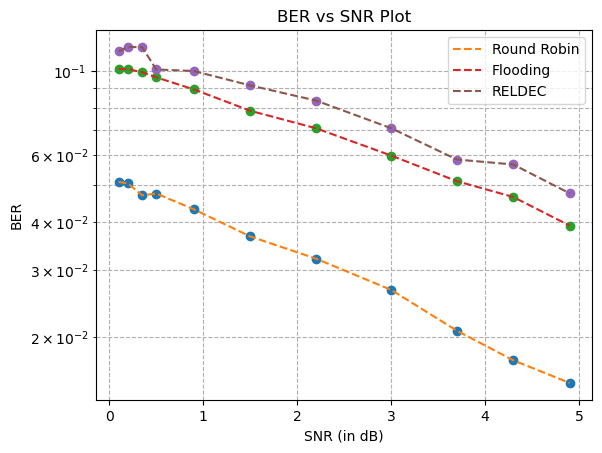

In [16]:
plt.plot(snrdb_vals, bers_rr, 'o')  
plt.plot(snrdb_vals, bers_rr, '--',label="Round Robin")
plt.plot(snrdb_vals, bers_flooding, 'o')  
plt.plot(snrdb_vals, bers_flooding, '--',label="Flooding")
plt.plot(snrdb_vals, bers_reldec, 'o')  
plt.plot(snrdb_vals, bers_reldec, '--',label="RELDEC")



plt.title("BER vs SNR Plot")
plt.ylabel("BER")
plt.xlabel("SNR (in dB)")
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")

